In [1]:
import os, sys, re, time, math, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import glob
from tqdm import tqdm
import random
from collections import defaultdict
import pickle
import textwrap
import seaborn as sns

%matplotlib inline

In [134]:
def print_list(path, num=10):
    with open(path, 'r') as f:
        print(os.path.basename(path))
        for enum, line in enumerate(f):
            if enum == num:
                break
            print("\t{}".format(line))

def get_line_num(path):
    c = 0
    try:
        with open(path, 'r') as f:    
            for line in f:
                c+=1
        return "{:,}".format(c)
    except:
        return "{:,}".format(c)

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()
    
def files(num = 0):
    clean_txt = [os.path.join(clean_dir, x) for x in os.listdir(clean_dir)]
    clean_txt.sort(key = lambda x: os.path.basename(x).lower())

    for enum, f in enumerate(clean_txt):
        print("{:>3d}: ".format(enum), end = "")
        print_list(f, num)
        
def choose_y(l, y, ymax, thres = 0.02, delt = 0.005):
    y_rat = y/ymax
    #print("\t\t{}".format(y_rat))
    
    while not valid_space(l, y_rat, thres):
        y_rat+=delt
    
    return y_rat


def valid_space(l, y, thres):
    for p in l:
        if abs(p-y) < thres:
            return False
    return True


def rolling_avg(x, y, num):
    x_res = x[num:]
    y_res = []
    for ind in range(num,len(y)):
        mean = np.mean(y[ind-num:ind])
        y_res.append(mean) 
    return x_res, y_res

def relative_change(y):
    y_last = y[0]
    change_last = 0
    res = []
    for val in y[1:]:
        diff = val - y_last
        #change = diff/y_last
        #res.append(change)
        res.append(diff)
        y_last = val
    return res

In [3]:
# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0

    while low <= high:
        mid = (high + low) // 2
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
        # means x is present at mid
        else:
            return mid

    # If we reach here, then the element was not present
    return -1


In [170]:
# set up folder dirs

#base_dir = '/media/billy/billy_256/inf_project' #
base_dir = '/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA'
data_dir = os.path.join(base_dir,'MAG')
clean_dir = os.path.join(base_dir,'clean_mag')
fig_dir = '/home/billy/Documents/DBMI/Classes/INFSCI-2415/project/final_figures'
temp_dir = os.path.join(base_dir, 'temp')
unzip_dir = os.path.join(base_dir, 'unzip')
pkl_dir = os.path.join(base_dir, 'pkl')

dir_list = [base_dir, data_dir, clean_dir, fig_dir, temp_dir, unzip_dir, pkl_dir]
for d in dir_list:
    print(d)
    os.makedirs(d, exist_ok = True)

/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA
/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA/MAG
/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA/clean_mag
/home/billy/Documents/DBMI/Classes/INFSCI-2415/project/final_figures
/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA/temp
/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA/unzip
/home/billy/Documents/DBMI/Classes/INFSCI-2415/MAG_DATA/pkl


In [12]:
clean_txt = [os.path.join(clean_dir, x) for x in os.listdir(clean_dir)]
clean_txt.sort(key = lambda x: os.path.basename(x).lower())

for enum, f in enumerate(clean_txt):
    print("{:>3d}: ".format(enum), end = "")
    print_list(f, 0)

  0: Affiliations.txt
  1: FieldId_name_level.txt
  2: id2name.txt
  3: journalEmbeddings.txt
  4: journalEmbeddingsVariables.txt
  5: Journals.txt
  6: Journals_WOS.txt
  7: Keyword2field_level0_frequency.txt
  8: Keyword2field_level1.txt
  9: Keyword2field_level1_frequency.txt
 10: Paper2authorInstitution.txt
 11: Paper2authors.txt
 12: Paper2field_level0.txt
 13: Paper2field_level0_frequency.txt
 14: paper2institution.txt
 15: Paper2teamsize.txt
 16: Paper2year.txt
 17: PaperFieldsOfStudy.txt
 18: Paperid_ReferredJournalids.txt
 19: Paperid_ReferredJournals.txt
 20: PaperMutipleInstitution.txt
 21: PaperReferences.txt


In [13]:
print_list(clean_txt[2], 5)

id2name.txt
	417682	night air

	1443462	immobiliser

	1576492	matrix pencil

	2657588	combinatorial topology

	3079626	quantum electrodynamics



In [14]:
#'Paper2year.txt = clean_txt[16]
#'Paper2teamsize.txt = clean_txt[15]
p2year_df = pd.read_csv(clean_txt[16], sep = '\t', header = None)
p2size_df = pd.read_csv(clean_txt[15], sep = '\t', header = None)
id2name_df = pd.read_csv(clean_txt[2], sep = '\t', header = None)

p2year_df.columns = ['paper_id', 'year']
p2size_df.columns = ['paper_id', 'team_size']
id2name_df.columsn = ['keyword_id', 'keyword']

paper_ys_df = pd.merge(p2year_df, p2size_df, on = 'paper_id', how = 'inner')

/home/billy/miniconda3/envs/inf2415/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [40]:
df_list = [p2year_df, p2size_df, id2name_df, paper_ys_df]
 
for d in df_list:
    display(d.head(5))

,paper_id,year
0,3084304917,2021
1,3092178912,2021
2,3093779216,2021
3,3064927307,2021
4,3089913340,2021


,paper_id,team_size
0,23,3
1,79,2
2,108,1
3,147,1
4,285,2


,0,1
0,417682,night air
1,1443462,immobiliser
2,1576492,matrix pencil
3,2657588,combinatorial topology
4,3079626,quantum electrodynamics


,paper_id,year,team_size
0,3084304917,2021,4
1,3092178912,2021,5
2,3093779216,2021,2
3,3064927307,2021,3
4,3089913340,2021,3


In [41]:
n=0
F=defaultdict(int)
with open(clean_txt[12], 'r') as f:
    loop = 0
    for line in f:
        loop+=1
        if loop%1000000 == 0:
            flushPrint("{:,}".format(loop))
        line = line.strip('\n').split('\t')
        line = [int(x) for x in line]
        fields = line[1:]
        for i in fields:
            F[int(i)]+=1
            n+=1

            
KD={}
with open(clean_txt[2], 'r') as f:
    for line in f:
        nid,field = line.strip('\n').split('\t') 
        KD[int(nid)]=field

142,000,000

In [58]:
#with open('/Users/ling/Dropbox/MAG_data/ling/Paper2field/Paper2field_level0.txt','r') as f:
paper_dict = defaultdict(int)
with open(clean_txt[12], 'r') as f:
    loop = 0
    try:
        for line in f:
            loop+=1
            if loop%1000000 == 0:
                flushPrint("{:,}".format(loop))
            if random.random() < 0.1:
                line = line.strip('\n').split('\t')
                line = [int(x) for x in line]
                paper_id = line[0]
                paper_dict[paper_id] = line[1]
    except KeyboardInterrupt:
        print("Keyboard interrupt")
        print("Loop ended at {}".format(loop))
        
    except Exception as e:
        print("Loop ended at {}".format(loop))
        print(e)
    finally:
        out_loc = os.path.join(pkl_dir, 'paper_dict.pkl')
        with open(out_loc, 'wb') as out_file:
            pickle.dump(paper_dict, out_file)
print(len(paper_dict))

142,000,00014232946


In [196]:
!python --version

Python 3.7.11


In [195]:
len(paper_dict)

14232946

In [60]:
paper_id = paper_dict.keys()
key_id = paper_dict.values()

paper_key_dict = {'paper_id':paper_id, 'key_id':key_id}
paper_key_df = pd.DataFrame.from_dict(paper_key_dict)

print(paper_key_df.shape)
paper_key_df.head(10)

(14232946, 2)


,paper_id,key_id
0,58,121332964
1,71577115,86803240
2,221784921,86803240
3,36065637,86803240
4,161689272,127413603
5,221785040,86803240
6,36065702,142362112
7,144555818,86803240
8,53957445,185592680
9,71577639,71924100


In [61]:
all_df = pd.merge(paper_ys_df, paper_key_df, on = 'paper_id', how = 'inner')
all_df

,paper_id,year,team_size,key_id
0,3085233678,2021,1,17744445
1,3080758898,2021,6,86803240
2,3090811895,2021,6,185592680
3,3037711136,2021,2,127413603
4,3094407606,2021,7,127413603
...,...,...,...,...
6573037,2620542396,1800,14,39432304
6573038,2064714645,1800,1,86803240
6573039,3092264291,1800,1,185592680
6573040,3091994355,1800,1,185592680


In [62]:
result_list_avg = {}
result_list_total = {}

for key_id in F.keys():
    print(KD[key_id])
    temp_df = all_df[all_df.iloc[:,3] == key_id]
    year_avg = {}
    year_total = {}
    for count, yr in enumerate(range(1800, 2022)): 
        small_df = temp_df.loc[:,'team_size'][temp_df.loc[:, 'year'] == yr]
        yr_sum = small_df.sum(axis = 0)
        yr_num = small_df.shape[0]
        if yr_num == 0:
            year_avg[yr] = 0
            year_total[yr] = 0
        else:
            year_avg[yr] = yr_sum/yr_num
            year_total[yr] = yr_num
            
    result_list_avg[key_id] = year_avg
    result_list_total[key_id] = year_total

physics
business
engineering
computer science
economics
history
medicine
psychology
biology
chemistry
geology
geography
sociology
political science
philosophy
mathematics
materials science
art
environmental science


In [78]:
top_ten = []
for k,v in result_list_avg.items():
    key = k
    year = list(v.keys())[-1]
    avg = list(v.values())[-1]
    top_ten.append((key,year, avg))

top_ten.sort(key=lambda x: x[2], reverse = True)

for enum, tt in enumerate(top_ten[0:10]):
    print("{:>3d} {} = {}".format(enum, tt[0], KD[tt[0]]))
    
top_ten_keys = [x[0] for x in top_ten[0:10]]
len(top_ten_keys)

  0 185592680 = chemistry
  1 86803240 = biology
  2 121332964 = physics
  3 39432304 = environmental science
  4 192562407 = materials science
  5 127413603 = engineering
  6 17744445 = political science
  7 142362112 = art
  8 71924100 = medicine
  9 127313418 = geology


10

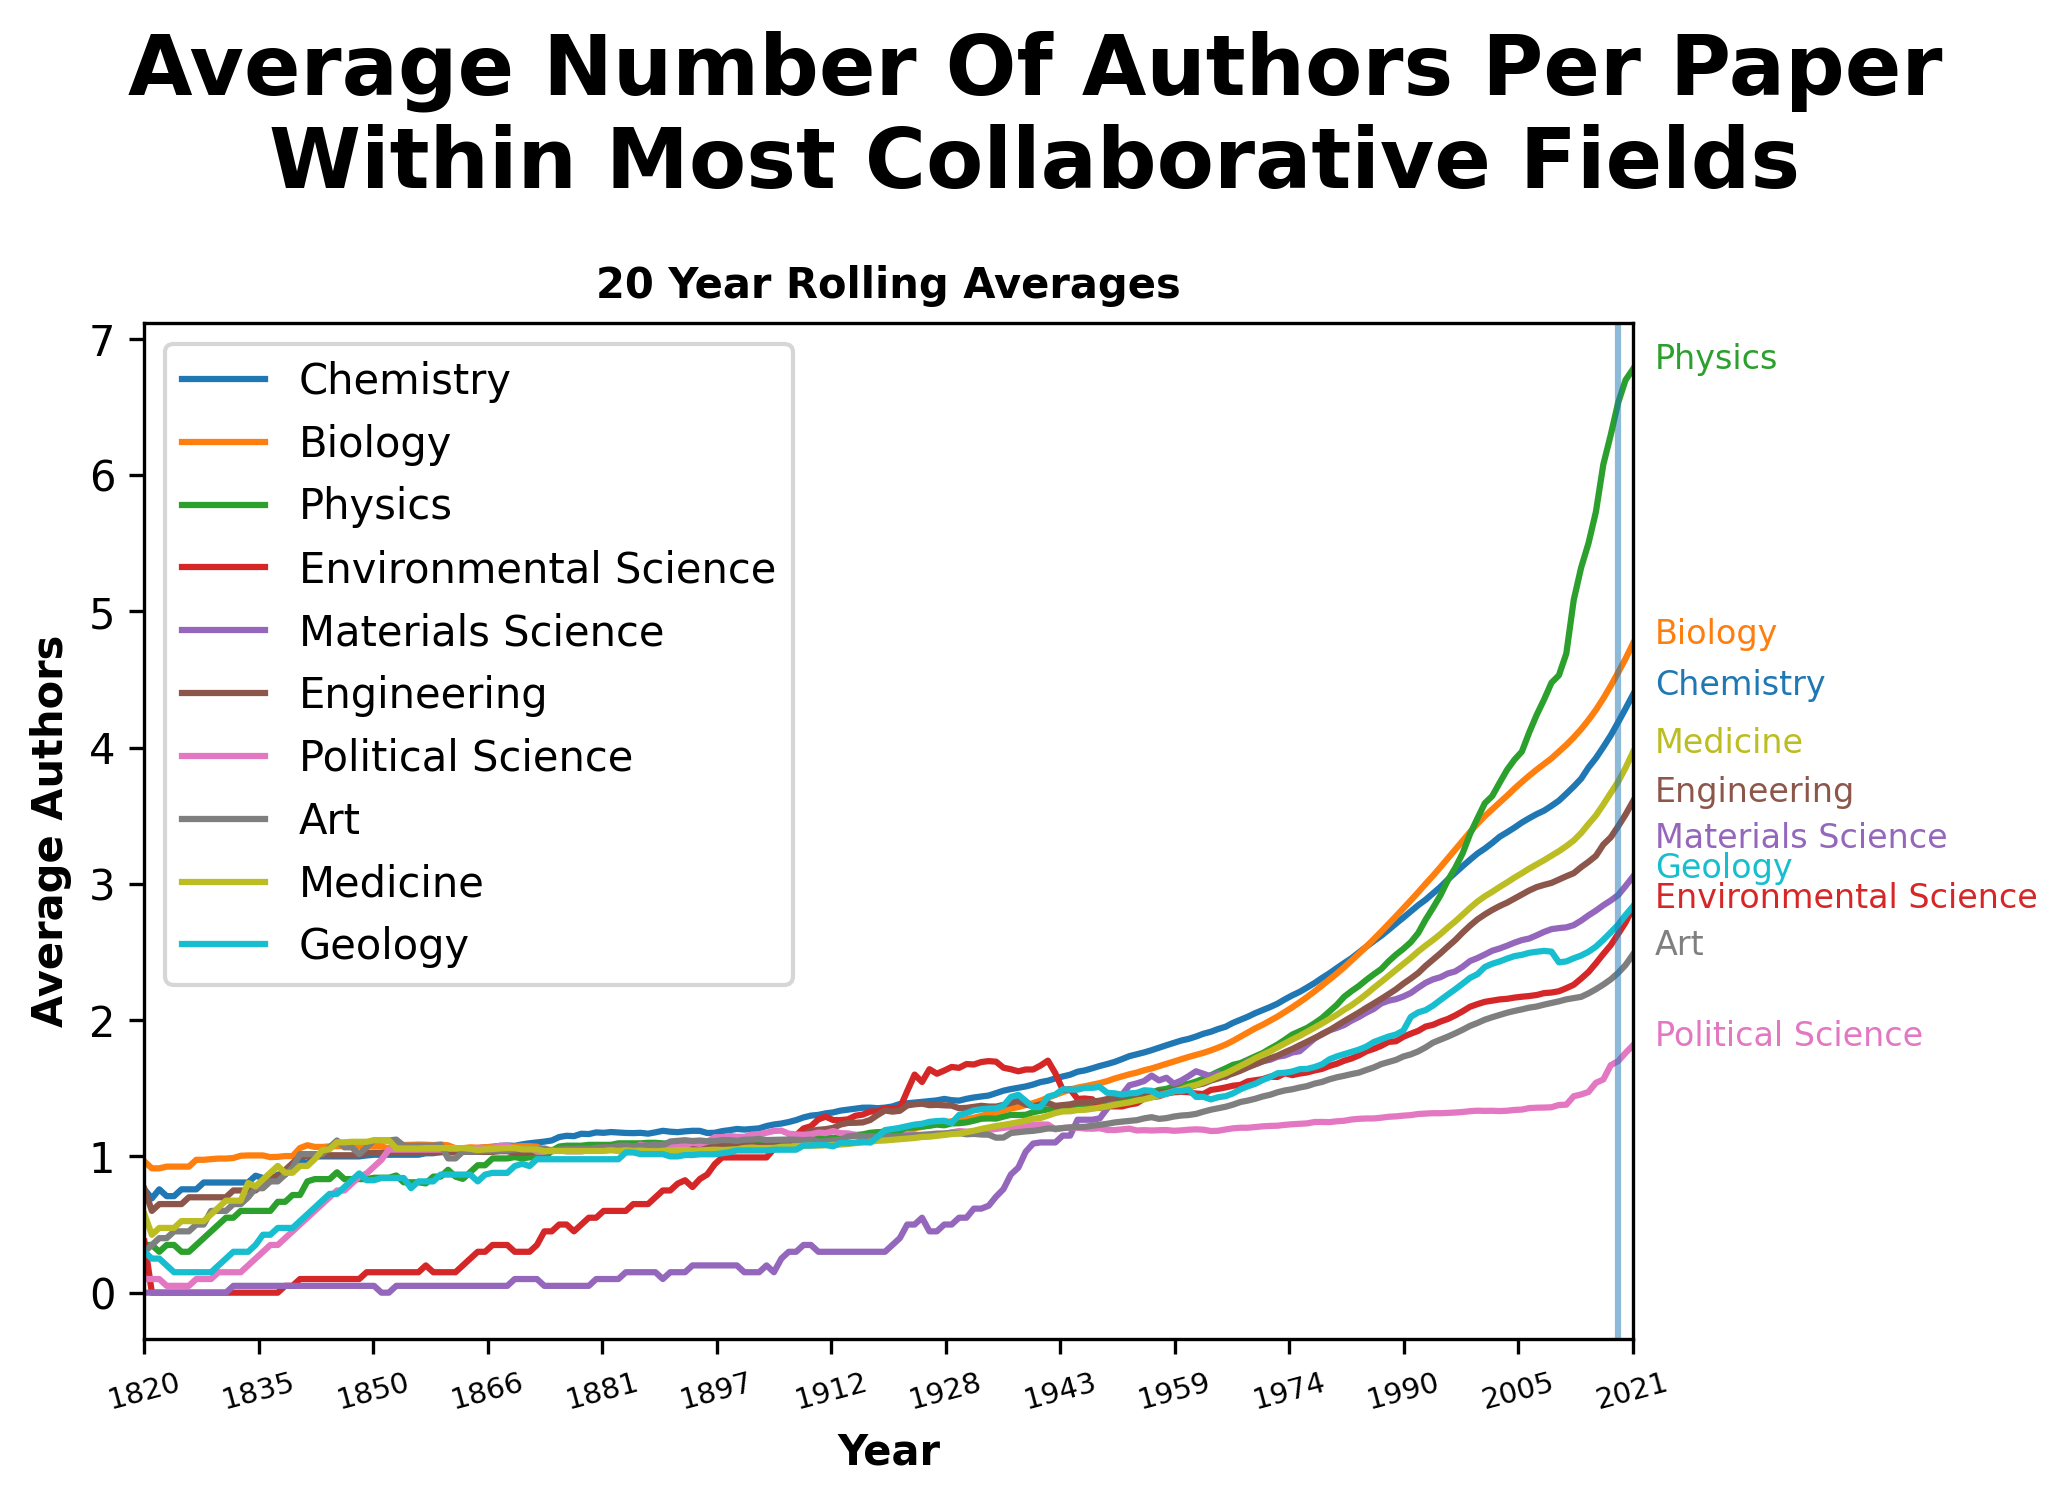

In [193]:
fig = plt.figure(figsize=(7, 5), dpi = 300, facecolor = 'white')
ax = fig.add_subplot(111)
used_y = []
text_pos = []
for key_id in top_ten_keys:
    d = result_list_avg[key_id]
    x = list(d.keys())
    y = list(d.values())
    x_smooth, y_smooth = rolling_avg(x, y, 20)    
    ax = plt.plot(x_smooth,y_smooth, label = KD[key_id].title())
    #ax = plt.plot(x,y, label = KD[key_id].title())
    text_pos.append((key_id, x_smooth[-1]+3, y_smooth[-1], ax[-1].get_color()))

text_pos.sort(key = lambda x: x[2])
y_max = plt.gca().get_ylim()[1]
for t in text_pos:
    y_pos = choose_y(used_y, t[2], y_max, thres = 0.03, delt = 0.005)
    used_y.append(y_pos)
    plt.text(t[1], y_pos*y_max, KD[t[0]].title(), color = t[3], fontsize = 8)

        
ax_new = plt.gca()
xticks = np.linspace(min(x_smooth), max(x_smooth), 14)
ax_new.set_xticks(xticks)
xticks = [int(x) for x in xticks]
ax_new.set_xticklabels(xticks, fontsize = 7)
        
plt.xlim([1820, 2021])
plt.axvline(x=2019, ymin = 0, alpha = 0.5)
title = 'Average Number of Authors per paper within most Collaborative fields'
title = textwrap.fill(title, 40)
subtitle = '20 year rolling averages'
fig.suptitle(title.title(), fontsize = 20, fontweight = 'bold', ha = 'center')
plt.title(subtitle.title(), fontsize = 10, fontweight = 'bold', ha = 'center')
plt.ylabel("Average Authors",fontweight = 'bold')
plt.xlabel("Year", fontweight = 'bold')
plt.legend()
plt.tight_layout()
plt.xticks(rotation = 15)
for end in ['.png', '.pdf']:
    save_name = os.path.join(fig_dir, 'fig1a' + end)
    plt.savefig(save_name, dpi = 300)
plt.show()

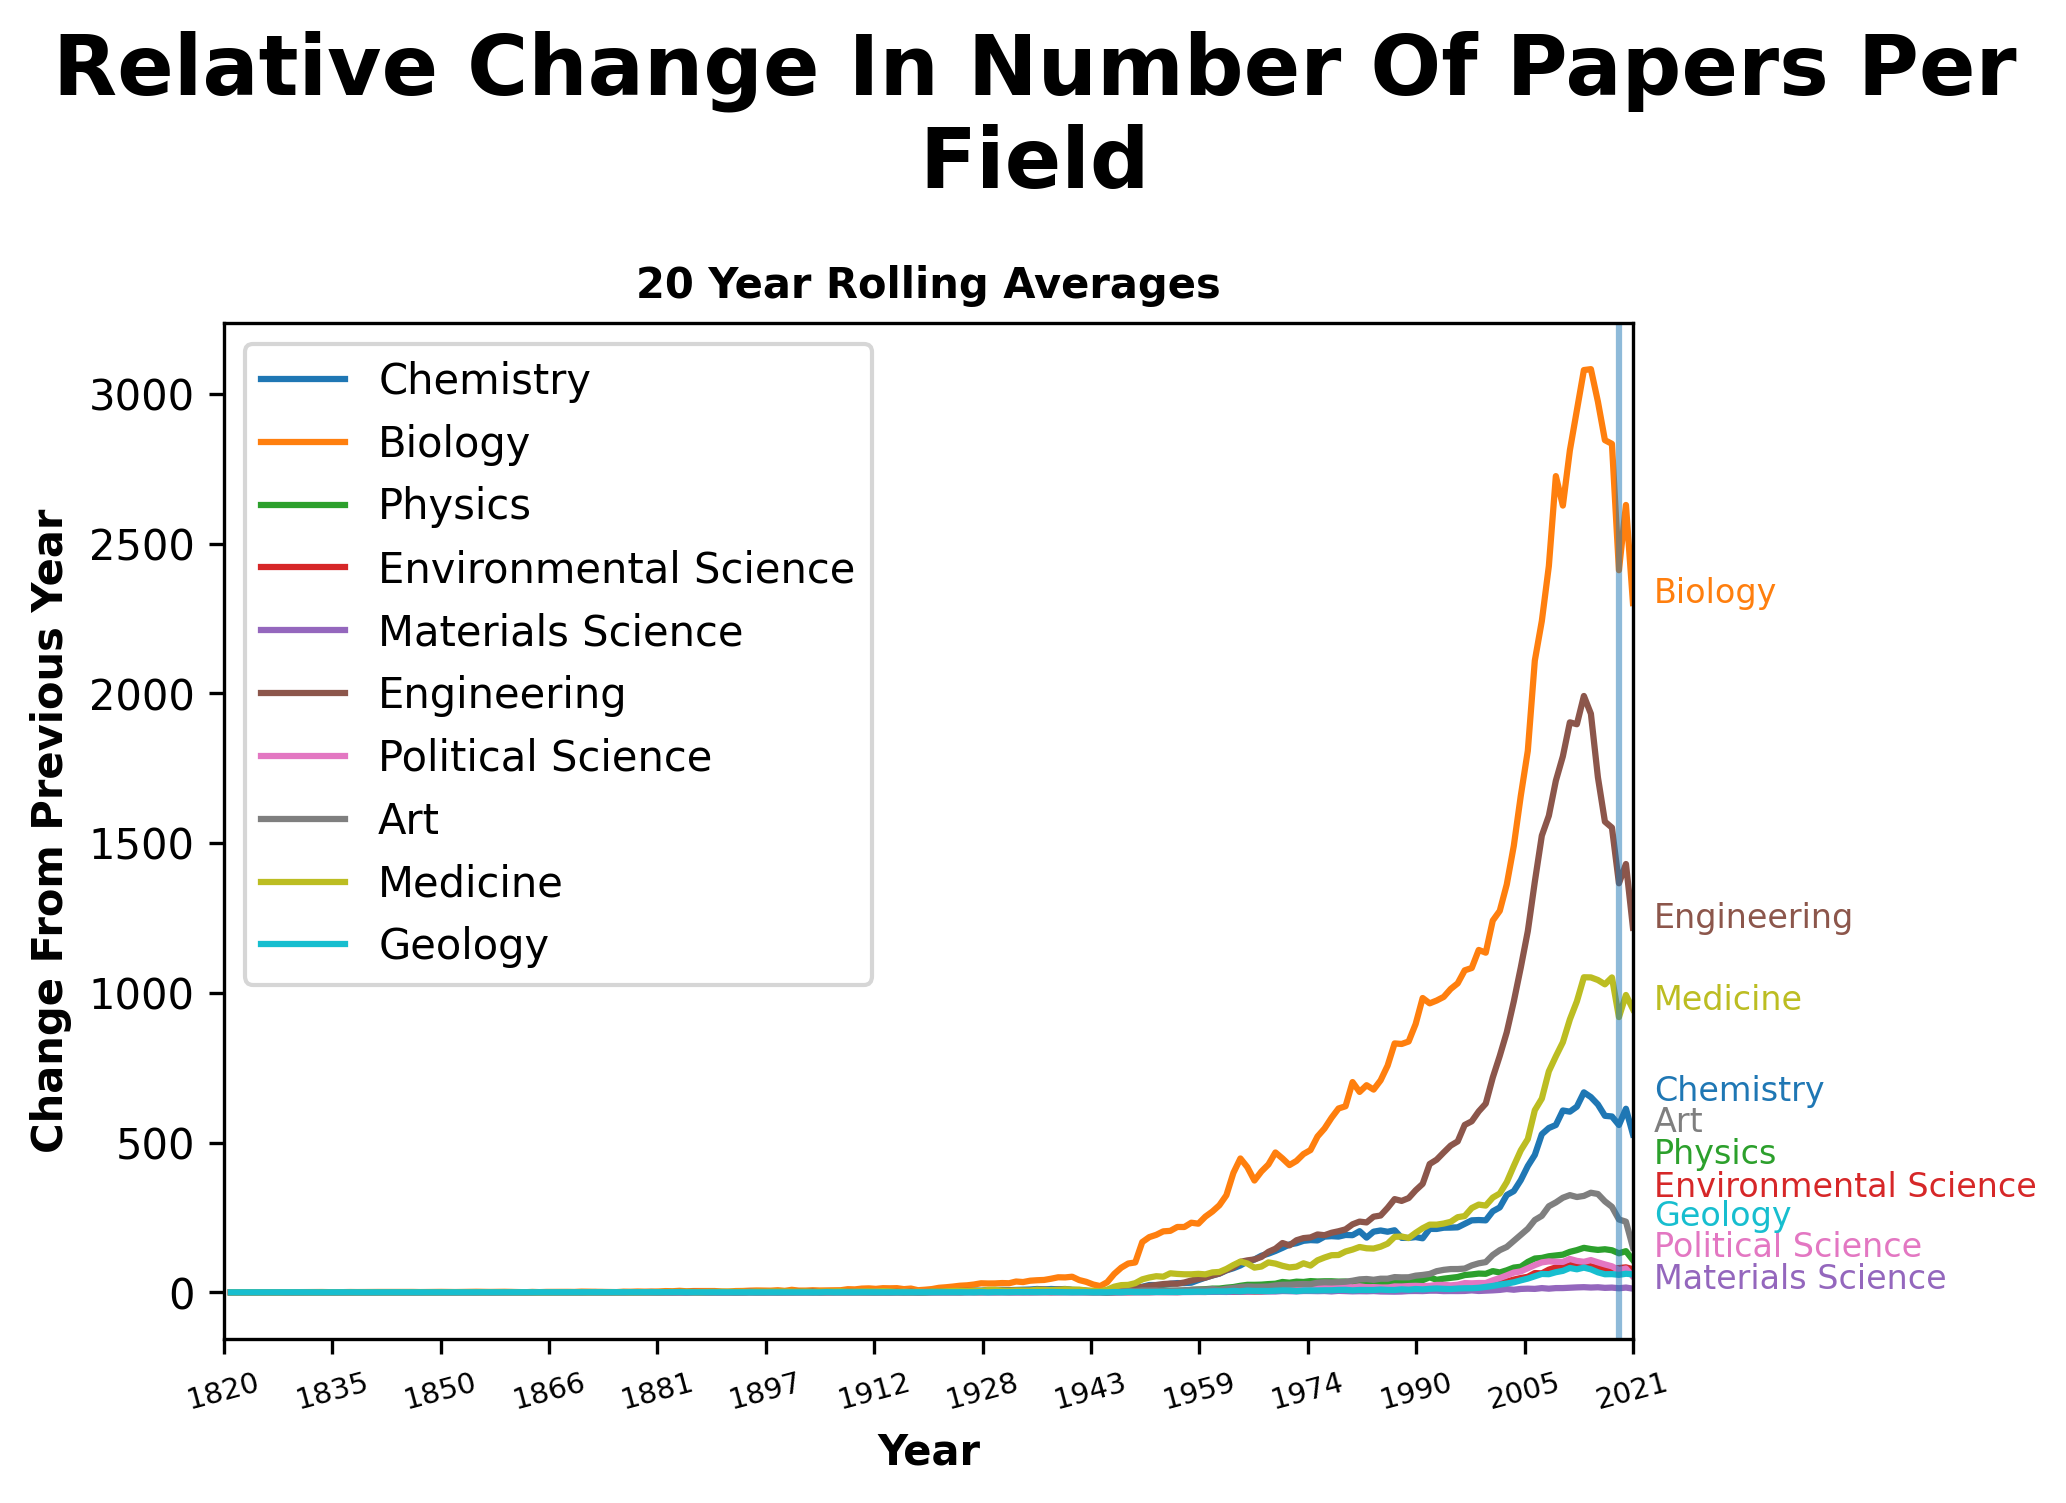

In [192]:
fig = plt.figure(figsize=(7,5), dpi = 300, facecolor = 'white')
ax = fig.add_subplot(111)
used_y = []
text_pos = []
for key_id in top_ten_keys:
    d = result_list_total[key_id]
    x = list(d.keys())
    y = list(d.values())
    x_smooth, y_smooth = rolling_avg(x, y, 20)   
    y_smooth_rel = relative_change(y_smooth)    
    ax = plt.plot(x_smooth[1:], y_smooth_rel, label = KD[key_id].title())
    #plt.text(, , KD[key_id], color = ax[-1].get_color())
    
    text_pos.append((key_id, x_smooth[-1]+3, y_smooth_rel[-1], ax[-1].get_color()))

text_pos.sort(key = lambda x: x[2])
y_max = plt.gca().get_ylim()[1]
for t in text_pos:
    y_pos = choose_y(used_y, t[2], y_max, thres = 0.03, delt = 0.005)
    used_y.append(y_pos)
    plt.text(t[1], y_pos*y_max, KD[t[0]].title(), color = t[3], fontsize = 8)
    
    
ax_new = plt.gca()
xticks = np.linspace(min(x_smooth), max(x_smooth), 14)
ax_new.set_xticks(xticks)
xticks = [int(x) for x in xticks]
ax_new.set_xticklabels(xticks, fontsize = 7)


plt.axvline(x=2019, ymin = 0, alpha = 0.5)
plt.xlim([1820, 2021])
title = 'Relative Change in Number of papers per field'
title = textwrap.fill(title, 40)
subtitle = '20 year rolling averages'
fig.suptitle(title.title(), fontsize = 20, fontweight = 'bold', ha = 'center')
plt.title(subtitle.title(), fontsize = 10, fontweight = 'bold', ha = 'center')
plt.ylabel("Change from previous year".title(),fontweight = 'bold')
plt.xlabel("Year", fontweight = 'bold')
plt.legend()
plt.tight_layout()
plt.xticks(rotation = 15)
for end in ['.png', '.pdf']:
    save_name = os.path.join(fig_dir, 'fig2a' + end)
    plt.savefig(save_name, dpi = 300)
plt.show()

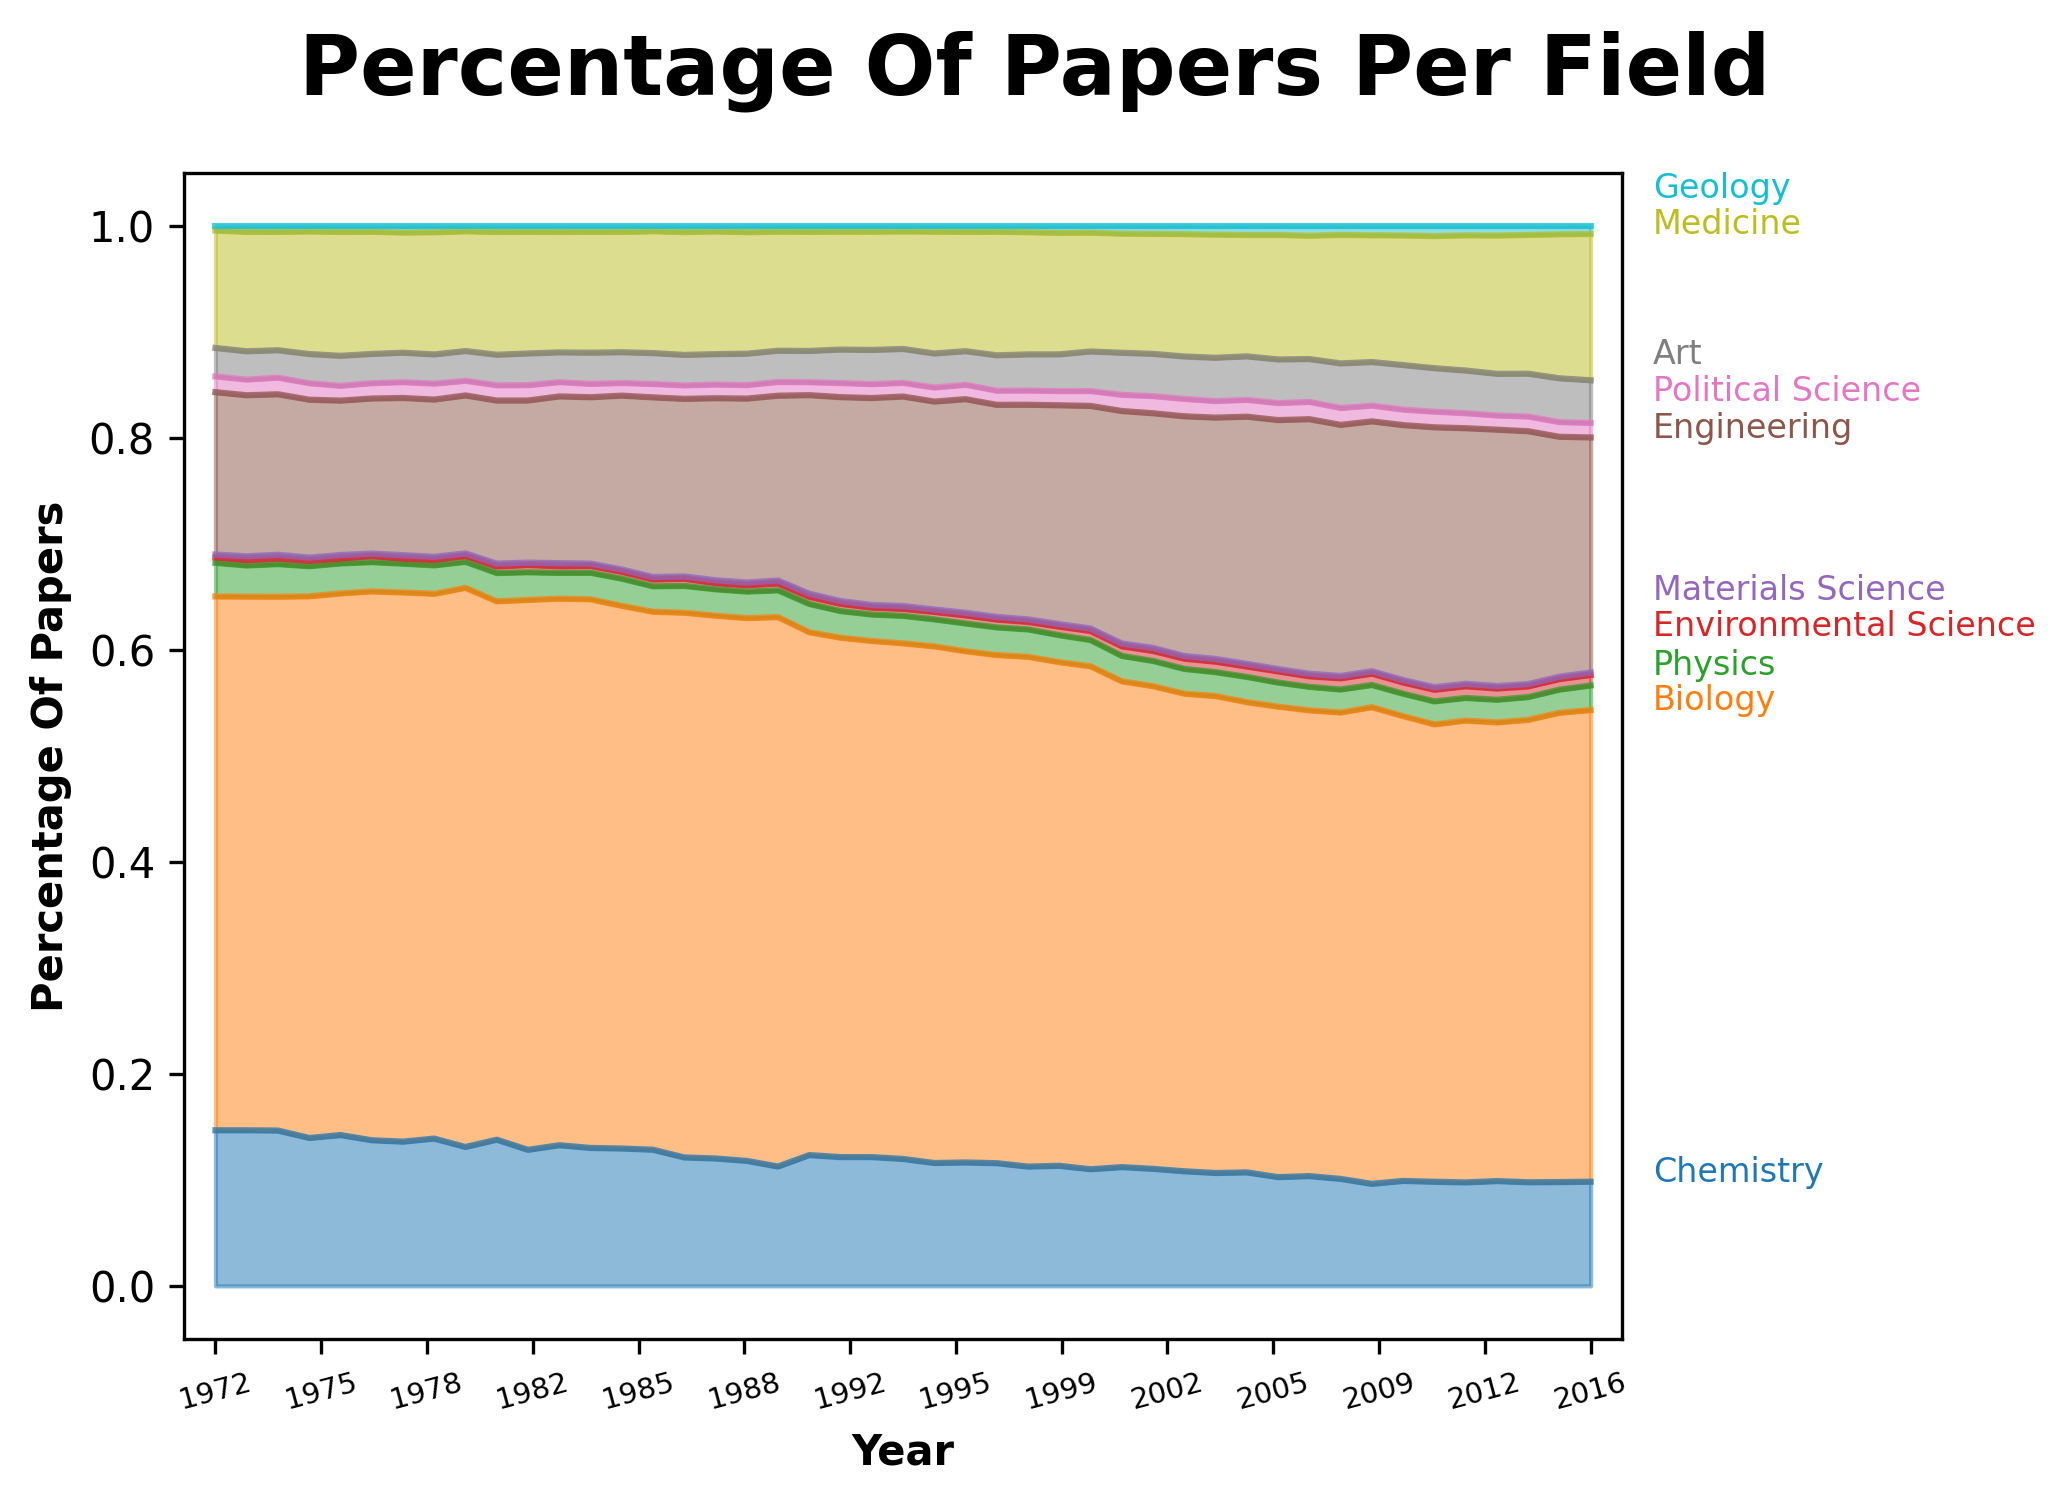

In [191]:
fig = plt.figure(figsize=(7,5), dpi = 300, facecolor = 'white')
ax = fig.add_subplot(111)

year_totals = defaultdict(int)
for key_id, d in result_list_total.items():
    if key_id in top_ten_keys:
        x = list(d.keys())
        y = list(d.values())
        for x_val, y_val in zip(x,y):
            year_totals[x_val]+=y_val
        
prev = None
used_y = []
text_pos = []
#for key_id, d in result_list_total.items():
for key_id in top_ten_keys:
    d = result_list_total[key_id]
    x = list(d.keys())[-50:-5]
    y = list(d.values())[-50:-5]
    y_per = [y_val/year_totals[x_val] for x_val, y_val in zip(x, y)]
    if prev is None:
        prev = [0 for i in range(len(y_per))]
    y_per = [i+j for i,j in zip(y_per, prev)]

    ax = plt.plot(x, y_per, label = KD[key_id].title(), alpha = 0.75)
    plt.fill_between(x, y_per, prev, color = ax[-1].get_color(), alpha = 0.5)
    prev = y_per
    #y_pos = choose_y(used_y, y_per[-1])
    #used_y.append(y_pos)
    #plt.text(, , KD[key_id], color = ax[-1].get_color())

    text_pos.append((key_id, x[-1]+2, y_per[-1], ax[-1].get_color()))

text_pos.sort(key = lambda x: x[2])
y_max = plt.gca().get_ylim()[1]
for t in text_pos:
    y_pos = choose_y(used_y, t[2], y_max, thres = 0.03, delt = 0.005)
    used_y.append(y_pos)
    plt.text(t[1], y_pos*y_max, KD[t[0]].title(), color = t[3], fontsize = 8)

ax_new = plt.gca()
xticks = np.linspace(min(x), max(x), 14)
ax_new.set_xticks(xticks)
xticks = [int(x) for x in xticks]
ax_new.set_xticklabels(xticks, fontsize = 7)

plt.axvline(x=2019, ymin = 0, alpha = 0.5)
plt.xlim([min(x)-1, max(x)+1])
title = 'Percentage of Papers per field'
title = textwrap.fill(title, 45)
#subtitle = '20 year rolling averages'
fig.suptitle(title.title(), fontsize = 20, fontweight = 'bold', ha = 'center')
#plt.title(subtitle.title(), fontsize = 10, fontweight = 'bold', ha = 'center')
plt.ylabel("Percentage of Papers".title(),fontweight = 'bold')
plt.xlabel("Year", fontweight = 'bold')
#plt.legend()
plt.tight_layout()
plt.xticks(rotation = 15)
for end in ['.png', '.pdf']:
    save_name = os.path.join(fig_dir, 'fig1b' + end)
    plt.savefig(save_name, dpi = 300)
plt.show()

/home/billy/miniconda3/envs/inf2415/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/billy/miniconda3/envs/inf2415/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


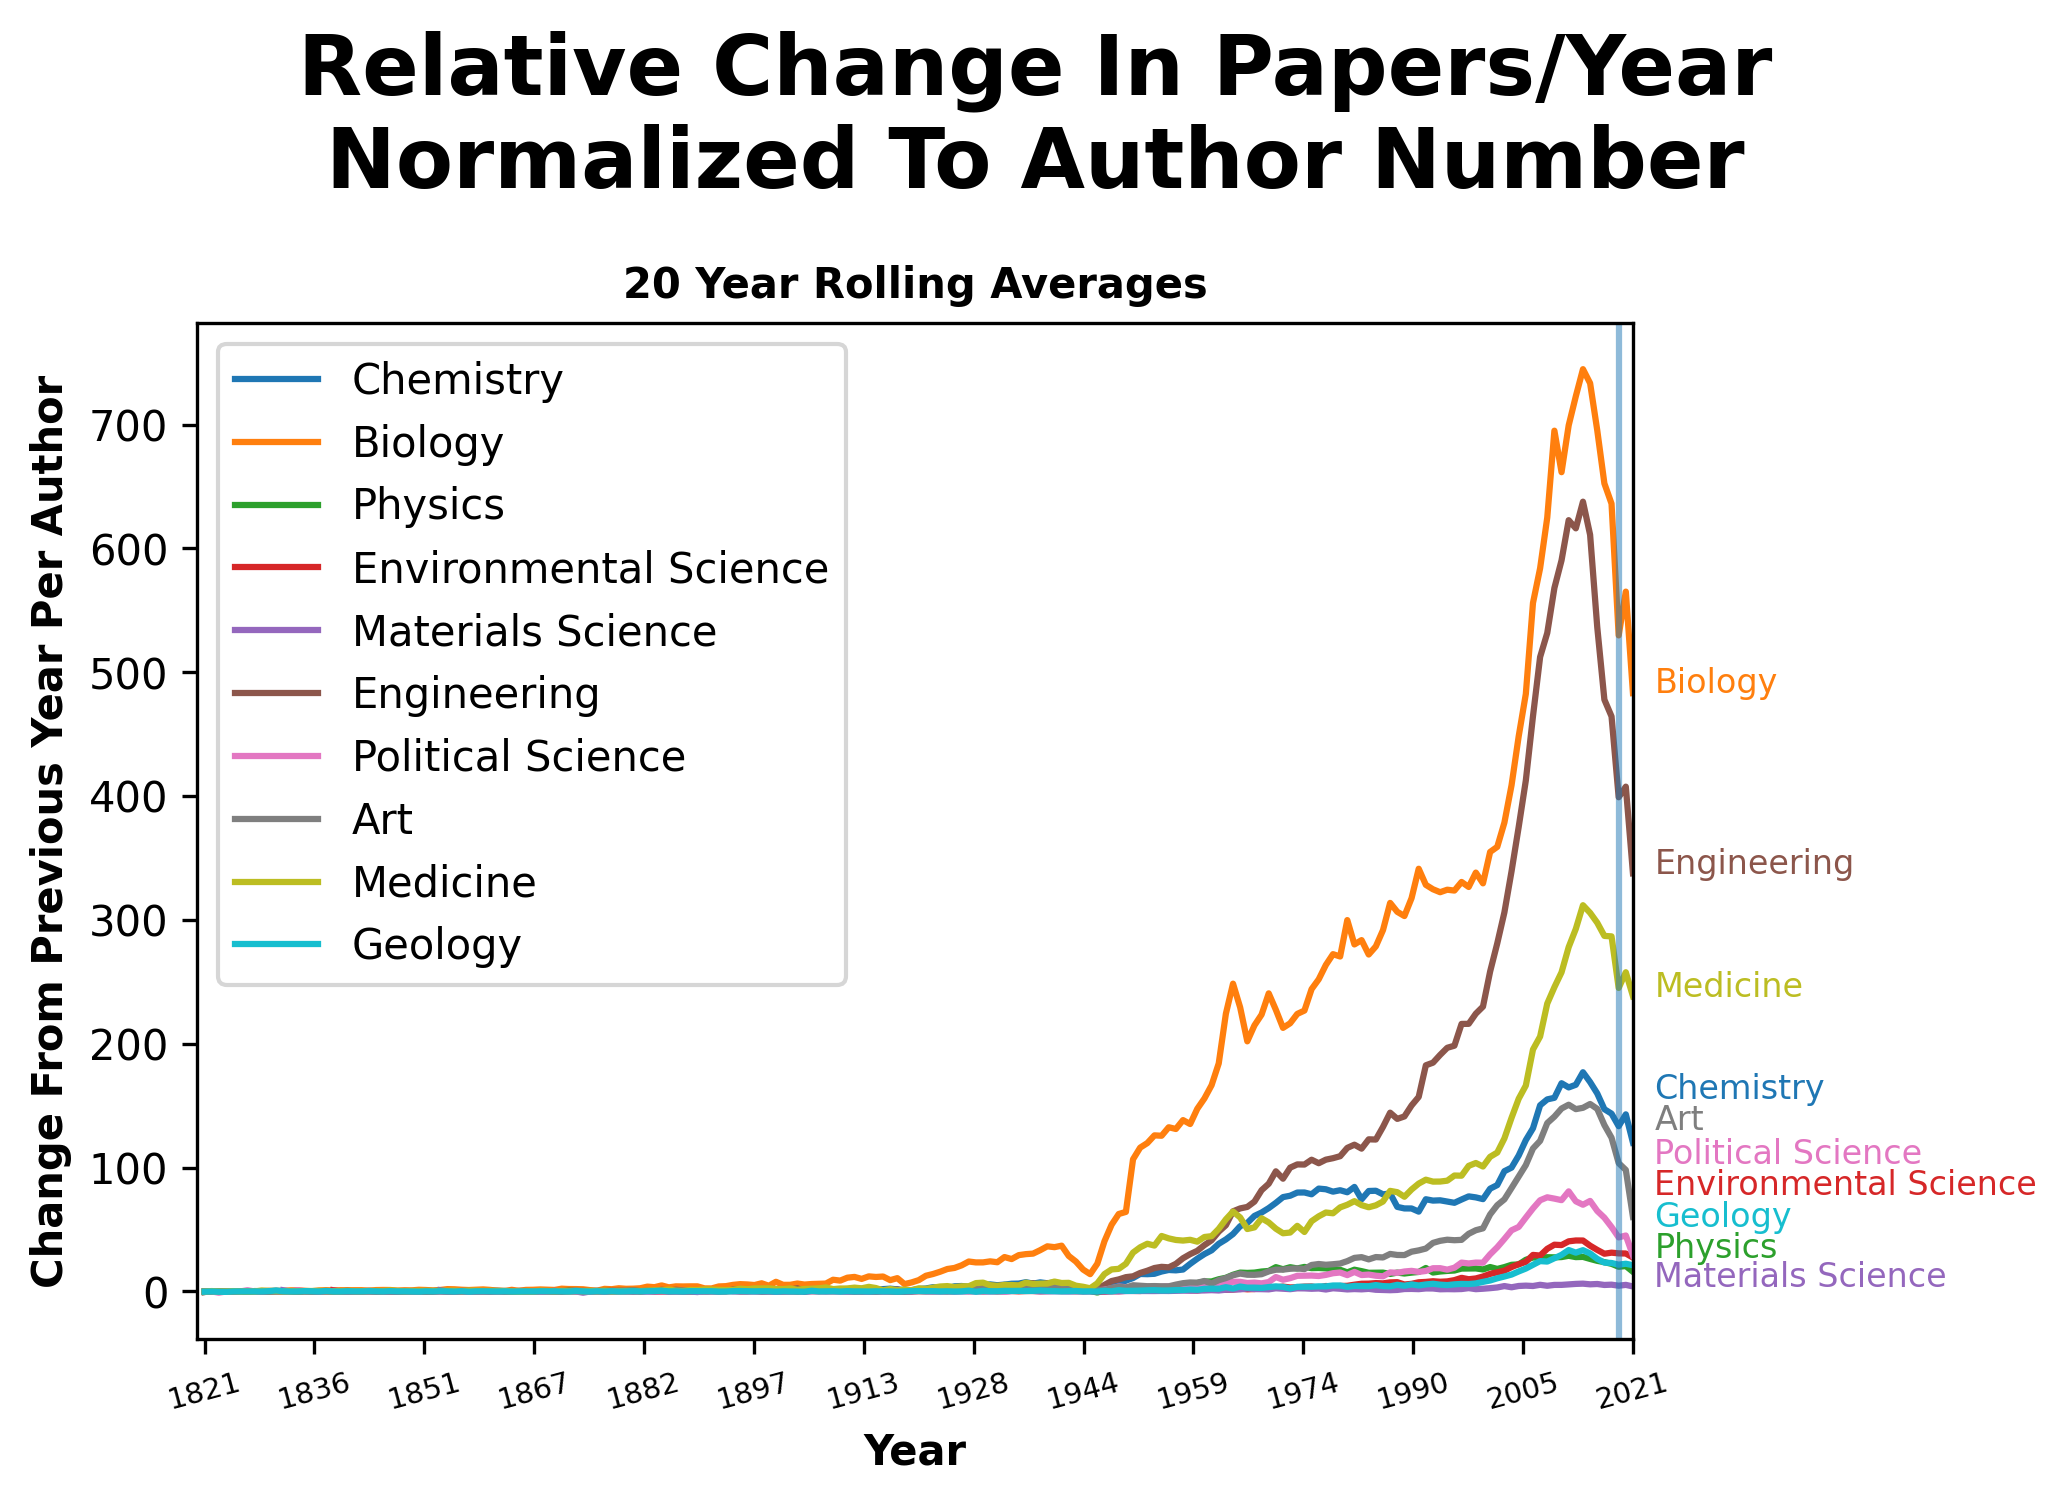

In [190]:
fig = plt.figure(figsize=(7,5), dpi = 300, facecolor = 'white')
ax = fig.add_subplot(111)
used_y = []
#for (key_id_1, d_1), (key_id_2, d_2) in zip(result_list_total.items(), result_list_avg.items()):
text_pos = []
for key_id in top_ten_keys:
        d_1 = result_list_total[key_id]
        d_2 = result_list_avg[key_id]
        x_1 = list(d_1.keys())
        y_1 = list(d_1.values())
        x_2 = list(d_2.keys())
        y_2 = list(d_2.values())
        
        x1_smooth, y1_smooth = rolling_avg(x_1, y_1, 20)
        x2_smooth, y2_smooth = rolling_avg(x_2, y_2, 20) 
        y1_smooth_rel = relative_change(y1_smooth)
        y2_smooth_rel = relative_change(y2_smooth)

        
        xplot = x_1[21:]
        yplot = [i / j for i, j in zip(y1_smooth_rel[:], y2_smooth[1:])]
        
        #xplot = x_1[20:-5]
        #yplot = [i / j for i, j in zip(y_1[20:-5], y2_smooth[:-5])]        
        ax = plt.plot(xplot, yplot, label = KD[key_id].title())
        #plt.text(, y_pos, KD[key_id_1], color = ax[-1].get_color(), fontsize = 7)
        
        text_pos.append((key_id, xplot[-1]+3, yplot[-1], ax[-1].get_color()))

text_pos.sort(key = lambda x: x[2])
y_max = plt.gca().get_ylim()[1]
for t in text_pos:
    y_pos = choose_y(used_y, t[2], y_max, thres = 0.03, delt = 0.005)
    used_y.append(y_pos)
    plt.text(t[1], y_pos*y_max, KD[t[0]].title(), color = t[3], fontsize = 8)

ax_new = plt.gca()
xticks = np.linspace(min(xplot), max(xplot), 14)
ax_new.set_xticks(xticks)
xticks = [int(x) for x in xticks]
ax_new.set_xticklabels(xticks, fontsize = 7)
        
plt.axvline(x=2019, ymin = 0, alpha = 0.5)
plt.xlim([1820, 2021])
title = 'Relative Change in Papers/Year normalized to Author number'
title = textwrap.fill(title, 40)
subtitle = '20 year rolling averages'
fig.suptitle(title.title(), fontsize = 20, fontweight = 'bold', ha = 'center')
plt.title(subtitle.title(), fontsize = 10, fontweight = 'bold', ha = 'center')
plt.ylabel("Change from previous year per Author".title(),fontweight = 'bold')
plt.xlabel("Year", fontweight = 'bold')
plt.legend()
plt.tight_layout()
plt.xticks(rotation = 15)
for end in ['.png', '.pdf']:
    save_name = os.path.join(fig_dir, 'fig2b' + end)
    plt.savefig(save_name, dpi = 300)
plt.show()

In [194]:
pkl_list = [
result_list_avg, # for figures
result_list_total, # for figures

top_ten_keys, #top fields
top_ten, #top fieldsfigures

all_df, # main df to make result dict above
p2year_df, 
p2size_df, 
id2name_df,
paper_ys_df
]

pkl_list_out = os.path.join(pkl_dir,'all_objs.pkl')

with open(pkl_list_out, 'wb') as f:
    pickle.dump(pkl_list, f)


In [ ]:
# for loading
pkl_list_out = os.path.join(pkl_dir,'all_objs.pkl')
with open(pkl_list_out, 'rb') as f:
    pkl_list_temp = pickle.load(f)
    
result_list_avg = pkl_list_temp[0]
result_list_total = pkl_list_temp[1]
top_ten_keys = pkl_list_temp[2]
top_ten = pkl_list_temp[3]
all_df = pkl_list_temp[4]
p2year_df = pkl_list_temp[5]
p2size_df = pkl_list_temp[6]
id2name_df = pkl_list_temp[7]
paper_ys_df = pkl_list_temp[8]

 # Below are save/load code blocks to load earlier df. 
 # convert to code chunk to run

## to save before exiting

main_df_loc = os.path.join(pkl_dir, 'paper_ys_df.pkl')
paper_ys_df.Fields = paper_ys_df.Fields.astype('Int64')
with open(main_df_loc, 'wb') as out_file:
    pickle.dump(paper_ys_df, out_file)

### Loading the DF
paper_ys_df.Fields = paper_ys_df.Fields.astype('Int64')
main_df_loc = os.path.join(pkl_dir, 'store_updated_paper_ys_df.pkl')
with open(main_df_loc, 'rb') as in_file:
    paper_ys_df = pickle.load(in_file)
    
paper_id_list = paper_ys_df.iloc[:,0].tolist()
paper_id_list = [int(x) for x in paper_id_list]

# SAVE 
paper2field_pkl_loc = os.path.join(pkl_dir, 'paper2field.pkl')
with open(paper2field_pkl_loc, 'wb') as out_file:
    pickle.dump(F, out_file)

# LOAD
paper2field_pkl_loc = os.path.join(pkl_dir, 'paper2field.pkl')
with open(paper2field_pkl_loc, 'rb') as in_file:
    F = pickle.load(in_file)